In [2]:
import gzip
import math
import numpy as np
import os
from PIL import Image
import random
import torch
import torch.utils.data as data

In [3]:
def load_mnist(root):
    # Load MNIST dataset for generating training data.
    path = os.path.join(root, 'data', 'Moving_MNIST', 'train-images-idx3-ubyte.gz')
    with gzip.open(path, 'rb') as f:
        mnist = np.frombuffer(f.read(), np.uint8, offset=16)
        mnist = mnist.reshape(-1, 28, 28)
    return mnist


def load_fixed_set(root, is_train):
    # Load the fixed dataset
    filename = 'mnist_test_seq.npy'
    path = os.path.join(root, 'data', 'Moving_MNIST', filename)
    dataset = np.load(path)
    dataset = dataset[..., np.newaxis]
    return dataset

In [4]:

images = load_mnist(root='../')

In [5]:
idx = np.random.randint(60000)
Image.fromarray(images[idx])

In [6]:
class MovingMNIST(data.Dataset):
    def __init__(self, root, is_train=True, n_frames_input=10, n_frames_output=10, num_objects=[2],
                 transform=None):
        '''
        param num_objects: a list of number of possible objects.
        '''
        super(MovingMNIST, self).__init__()

        self.dataset = None
        if is_train:
            self.mnist = load_mnist(root)
        else:
            if num_objects[0] != 2:
                self.mnist = load_mnist(root)
            else:
                self.dataset = load_fixed_set(root, False)
        self.length = int(1e4) if self.dataset is None else self.dataset.shape[1]

        self.is_train = is_train
        self.num_objects = num_objects
        self.n_frames_input = n_frames_input
        self.n_frames_output = n_frames_output
        self.n_frames_total = self.n_frames_input + self.n_frames_output
        self.transform = transform
        # For generating data
        self.image_size_ = 64
        self.digit_size_ = 28
        self.step_length_ = 0.1

    def get_random_trajectory(self, seq_length):
        ''' Generate a random sequence of a MNIST digit '''
        canvas_size = self.image_size_ - self.digit_size_
        x = random.random()
        y = random.random()
        theta = random.random() * 2 * np.pi
        v_y = np.sin(theta)
        v_x = np.cos(theta)

        start_y = np.zeros(seq_length)
        start_x = np.zeros(seq_length)
        for i in range(seq_length):
            # Take a step along velocity.
            y += v_y * self.step_length_
            x += v_x * self.step_length_

            # Bounce off edges.
            if x <= 0:
                x = 0
                v_x = -v_x
            if x >= 1.0:
                x = 1.0
                v_x = -v_x
            if y <= 0:
                y = 0
                v_y = -v_y
            if y >= 1.0:
                y = 1.0
                v_y = -v_y
            start_y[i] = y
            start_x[i] = x

        # Scale to the size of the canvas.
        start_y = (canvas_size * start_y).astype(np.int32)
        start_x = (canvas_size * start_x).astype(np.int32)
        return start_y, start_x

    def generate_moving_mnist(self, num_digits=2):
        '''
        Get random trajectories for the digits and generate a video.
        '''
        data = np.zeros((self.n_frames_total, self.image_size_, self.image_size_), dtype=np.float32)
        for n in range(num_digits):
            # Trajectory
            start_y, start_x = self.get_random_trajectory(self.n_frames_total)
            ind = random.randint(0, self.mnist.shape[0] - 1)
            digit_image = self.mnist[ind]
            for i in range(self.n_frames_total):
                top = start_y[i]
                left = start_x[i]
                bottom = top + self.digit_size_
                right = left + self.digit_size_
                # Draw digit
                data[i, top:bottom, left:right] = np.maximum(data[i, top:bottom, left:right], digit_image)

        data = data[..., np.newaxis]
        return data

    def __getitem__(self, idx):
        length = self.n_frames_input + self.n_frames_output
        if self.is_train or self.num_objects[0] != 2:
            # Sample number of objects
            num_digits = random.choice(self.num_objects)
            # Generate data on the fly
            images = self.generate_moving_mnist(num_digits)
        else:
            images = self.dataset[:, idx, ...]

        # if self.transform is not None:
        #     images = self.transform(images)

        r = 1 # patch size (a 4 dans les PredRNN)
        w = int(64 / r)
        images = images.reshape((length, w, r, w, r)).transpose(0, 2, 4, 1, 3).reshape((length, r * r, w, w))

        input = images[:self.n_frames_input]
        if self.n_frames_output > 0:
            output = images[self.n_frames_input:length]
        else:
            output = []

        frozen = input[-1]
        # add a wall to input data
        # pad = np.zeros_like(input[:, 0])
        # pad[:, 0] = 1
        # pad[:, pad.shape[1] - 1] = 1
        # pad[:, :, 0] = 1
        # pad[:, :, pad.shape[2] - 1] = 1
        #
        # input = np.concatenate((input, np.expand_dims(pad, 1)), 1)

        output = torch.from_numpy(output / 255.0).contiguous().float()
        input = torch.from_numpy(input / 255.0).contiguous().float()
        # print()
        # print(input.size())
        # print(output.size())

        out = [idx,input,output]
        return out

    def __len__(self):
        return self.length

In [7]:
train_dataset = MovingMNIST(root='../', is_train=True, n_frames_output=1)

In [8]:
idx = np.random.randint(len(train_dataset))
example = train_dataset[idx]

in_arr = example[1].numpy().reshape((-1, 64, 64))
out_arr = example[2].numpy().reshape((-1, 64, 64))

in_arr *= 255
in_arr = in_arr.astype(np.uint8)

out_arr *= 255
out_arr = out_arr.astype(np.uint8)

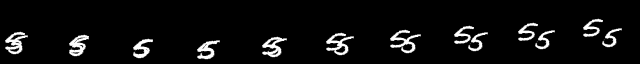

In [9]:
Image.fromarray(np.concatenate(in_arr, axis=1))

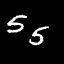

In [10]:
Image.fromarray(np.concatenate(out_arr, axis=1))